# 05 - Análisis Descriptivo: Delito/Arma Dominante por Municipio

## Descripción

Análisis descriptivo del dataset de **delitos y armas dominantes por municipio-año-mes** para generar estadísticas agregadas, rankings y resúmenes listos para usar en:
- **Tablero web**: Visualizaciones, métricas y mapas de riesgo
- **Chatbot comunitario**: Respuestas contextualizadas sobre criminalidad

## Objetivo

Generar archivos JSON con información precalculada que responda preguntas como:
- ¿Cuál es el delito más común en mi municipio?
- ¿Ha aumentado o disminuido la violencia este año?
- ¿Qué meses son más peligrosos?
- ¿Cómo se compara mi municipio con otros?

## ¿Qué hace este notebook?

| Sección | Descripción |
|---------|-------------|
| **1. Estadísticas Generales** | Métricas globales de Santander, distribución de delitos y armas |
| **2. Análisis Temporal** | Tendencias anuales, estacionalidad mensual, evolución del delito dominante |
| **3. Rankings** | Top municipios por criminalidad, clasificación de riesgo (Bajo/Medio/Alto) |
| **4. Resúmenes para Chatbot** | Descripciones en lenguaje natural por municipio |
| **5. Guardar Resultados** | Exporta 4 archivos JSON |
| **6. Ejemplo de Uso** | Simulación de consultas al chatbot |

## Diferencia con Modelo Predictivo

| Aspecto | Este Notebook (Descriptivo) | Notebook Predictivo |
|---------|----------------------------|---------------------|
| Pregunta | ¿Qué pasó? ¿Qué está pasando? | ¿Qué pasará? |
| Output | Archivos JSON con estadísticas | Modelo .joblib |
| Uso principal | Tablero + Chatbot (explicar) | Alertas + Predicciones |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'classification_dominant_dataset.parquet'

# Ruta de salida para modelo descriptivo
OUTPUT_DIR = BASE_DIR / 'models' / 'descriptivo' / 'classification_dominant'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Datos: {DATA_PATH}")
print(f"📁 Output: {OUTPUT_DIR}")

📁 Datos: /home/byverbel/challenges/Datos-al-Ecosistema/data/gold/model/classification_dominant_dataset.parquet
📁 Output: /home/byverbel/challenges/Datos-al-Ecosistema/models/descriptivo/classification_dominant


In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nPeríodo: {df['anio'].min()} - {df['anio'].max()}")
print(f"Municipios únicos: {df['codigo_municipio'].nunique()}")
df.head()

Shape: (16704, 7)

Columnas: ['codigo_municipio', 'anio', 'mes', 'delito_dominante', 'count_delito', 'arma_dominante', 'count_arma']

Período: 2010 - 2025
Municipios únicos: 87


,codigo_municipio,anio,mes,delito_dominante,count_delito,arma_dominante,count_arma
0,68001,2010,1,LESIONES,160,CONTUNDENTES,84
1,68001,2010,2,LESIONES,140,NO REPORTADO,82
2,68001,2010,3,LESIONES,164,NO REPORTADO,99
3,68001,2010,4,LESIONES,181,NO REPORTADO,111
4,68001,2010,5,LESIONES,164,NO REPORTADO,113


---
## 1. Estadísticas Generales del Departamento

In [3]:
# 1.1 Estadísticas generales
print("=" * 60)
print("ESTADÍSTICAS GENERALES DE SANTANDER")
print("=" * 60)

# Totales
total_registros = len(df)
total_delitos = df['count_delito'].sum()
municipios = df['codigo_municipio'].nunique()
anio_min = df['anio'].min()
anio_max = df['anio'].max()

# Delito más común globalmente
delito_mas_comun = df['delito_dominante'].value_counts().idxmax()
delito_mas_comun_pct = (df['delito_dominante'].value_counts().max() / len(df) * 100)

# Arma más común globalmente
arma_mas_comun = df['arma_dominante'].value_counts().idxmax()
arma_mas_comun_pct = (df['arma_dominante'].value_counts().max() / len(df) * 100)

print(f"\n📊 Período de análisis: {anio_min} - {anio_max}")
print(f"📊 Total de municipios: {municipios}")
print(f"📊 Total de registros (municipio-mes): {total_registros:,}")
print(f"📊 Suma total de delitos dominantes: {total_delitos:,}")
print(f"\n🔴 Delito dominante más frecuente: {delito_mas_comun} ({delito_mas_comun_pct:.1f}%)")
print(f"🔧 Arma dominante más frecuente: {arma_mas_comun} ({arma_mas_comun_pct:.1f}%)")

# Guardar estadísticas generales
stats_generales = {
    'periodo': {'inicio': int(anio_min), 'fin': int(anio_max)},
    'total_municipios': int(municipios),
    'total_registros': int(total_registros),
    'suma_delitos_dominantes': int(total_delitos),
    'delito_mas_frecuente': {
        'nombre': str(delito_mas_comun),
        'porcentaje': round(delito_mas_comun_pct, 2)
    },
    'arma_mas_frecuente': {
        'nombre': str(arma_mas_comun),
        'porcentaje': round(arma_mas_comun_pct, 2)
    }
}

ESTADÍSTICAS GENERALES DE SANTANDER

📊 Período de análisis: 2010 - 2025
📊 Total de municipios: 87
📊 Total de registros (municipio-mes): 16,704
📊 Suma total de delitos dominantes: 155,687

🔴 Delito dominante más frecuente: LESIONES (35.4%)
🔧 Arma dominante más frecuente: CONTUNDENTES (34.4%)



DISTRIBUCIÓN DE DELITOS DOMINANTES

📊 Frecuencia de cada delito como dominante:
   LESIONES: 5,916 veces (35.42%)
   ABIGEATO: 4,200 veces (25.14%)
   HURTOS: 1,976 veces (11.83%)
   AMENAZAS: 1,922 veces (11.51%)
   VIOLENCIA INTRAFAMILIAR: 1,380 veces (8.26%)
   DELITOS SEXUALES: 910 veces (5.45%)
   HOMICIDIOS: 331 veces (1.98%)
   EXTORSION: 69 veces (0.41%)


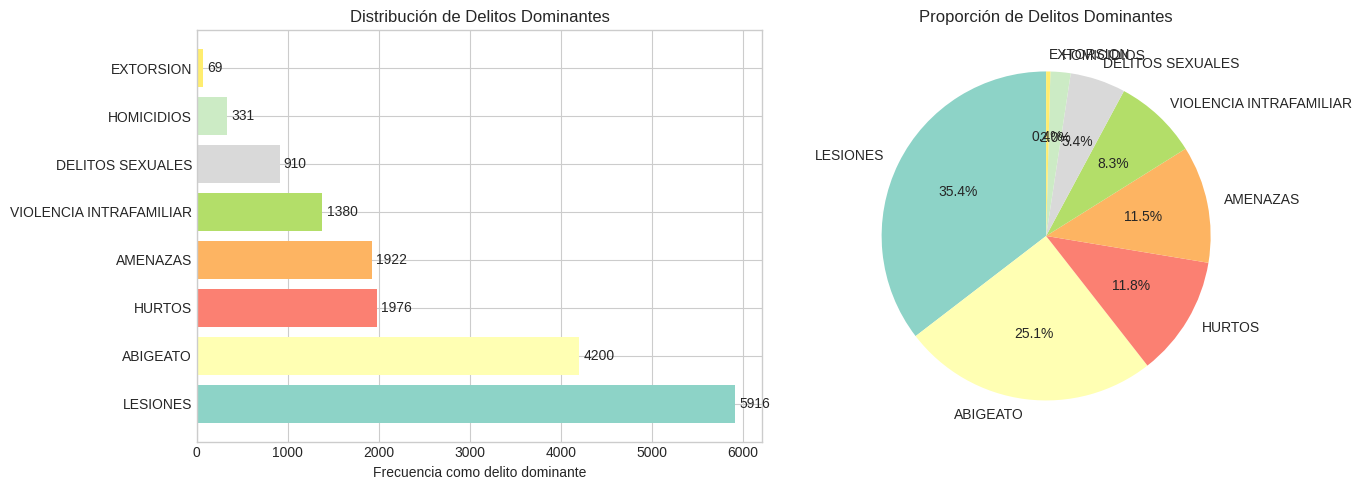

In [4]:
# 1.2 Distribución de delitos dominantes
print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE DELITOS DOMINANTES")
print("=" * 60)

delitos_dist = df['delito_dominante'].value_counts()
delitos_pct = (delitos_dist / len(df) * 100).round(2)

print("\n📊 Frecuencia de cada delito como dominante:")
for delito, count in delitos_dist.items():
    pct = delitos_pct[delito]
    print(f"   {delito}: {count:,} veces ({pct}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot
colors = plt.cm.Set3(np.linspace(0, 1, len(delitos_dist)))
ax1 = axes[0]
bars = ax1.barh(delitos_dist.index.astype(str), delitos_dist.values, color=colors)
ax1.set_xlabel('Frecuencia como delito dominante')
ax1.set_title('Distribución de Delitos Dominantes')
ax1.bar_label(bars, fmt='%d', padding=3)

# Pie chart
ax2 = axes[1]
ax2.pie(delitos_dist.values, labels=delitos_dist.index.astype(str), autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Proporción de Delitos Dominantes')

plt.tight_layout()
plt.show()

# Guardar distribución
stats_generales['distribucion_delitos'] = {
    str(k): {'frecuencia': int(v), 'porcentaje': float(delitos_pct[k])} 
    for k, v in delitos_dist.items()
}


DISTRIBUCIÓN DE ARMAS DOMINANTES

📊 Frecuencia de cada arma como dominante (Top 10):
   CONTUNDENTES: 5,740 veces (34.36%)
   ACIDO: 4,094 veces (24.51%)
   SIN EMPLEO DE ARMAS: 3,521 veces (21.08%)
   ARMA BLANCA / CORTOPUNZANTE: 1,308 veces (7.83%)
   NO REPORTADO: 1,200 veces (7.18%)
   ARMA DE FUEGO: 502 veces (3.01%)
   VEHICULO: 111 veces (0.66%)
   MOTO: 73 veces (0.44%)
   PALANCAS: 39 veces (0.23%)
   LLAMADA TELEFONICA: 32 veces (0.19%)


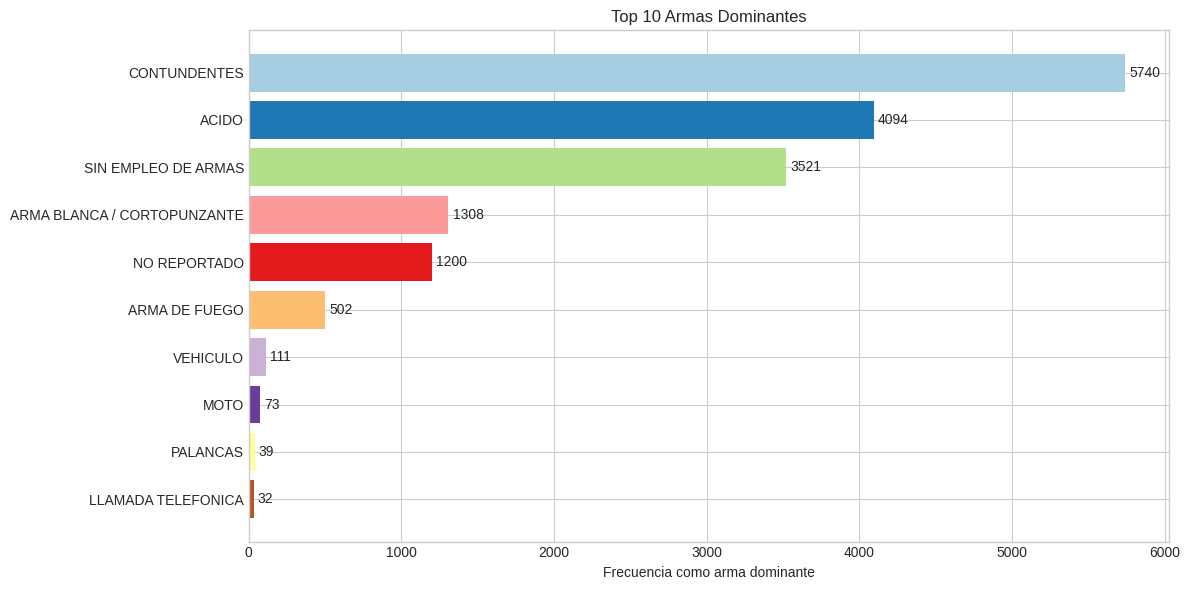

In [5]:
# 1.3 Distribución de armas dominantes
print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE ARMAS DOMINANTES")
print("=" * 60)

armas_dist = df['arma_dominante'].value_counts()
armas_pct = (armas_dist / len(df) * 100).round(2)

print("\n📊 Frecuencia de cada arma como dominante (Top 10):")
for arma, count in armas_dist.head(10).items():
    pct = armas_pct[arma]
    print(f"   {arma}: {count:,} veces ({pct}%)")

# Visualización (Top 10)
fig, ax = plt.subplots(figsize=(12, 6))
top_armas = armas_dist.head(10)
colors = plt.cm.Paired(np.linspace(0, 1, len(top_armas)))
bars = ax.barh(top_armas.index.astype(str), top_armas.values, color=colors)
ax.set_xlabel('Frecuencia como arma dominante')
ax.set_title('Top 10 Armas Dominantes')
ax.bar_label(bars, fmt='%d', padding=3)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Guardar distribución
stats_generales['distribucion_armas'] = {
    str(k): {'frecuencia': int(v), 'porcentaje': float(armas_pct[k])} 
    for k, v in armas_dist.items()
}

---
## 2. Análisis Temporal (Tendencias)

TENDENCIAS ANUALES

📊 Suma de delitos dominantes por año:
   2010: 7,488 
   2011: 7,978 (+6.5%)
   2012: 8,232 (+3.2%)
   2013: 8,361 (+1.6%)
   2014: 7,824 (-6.4%)
   2015: 7,740 (-1.1%)
   2016: 8,297 (+7.2%)
   2017: 9,076 (+9.4%)
   2018: 15,359 (+69.2%)
   2019: 15,589 (+1.5%)
   2020: 8,025 (-48.5%)
   2021: 7,874 (-1.9%)
   2022: 6,631 (-15.8%)
   2023: 9,939 (+49.9%)
   2024: 8,310 (-16.4%)
   2025: 18,964 (+128.2%)


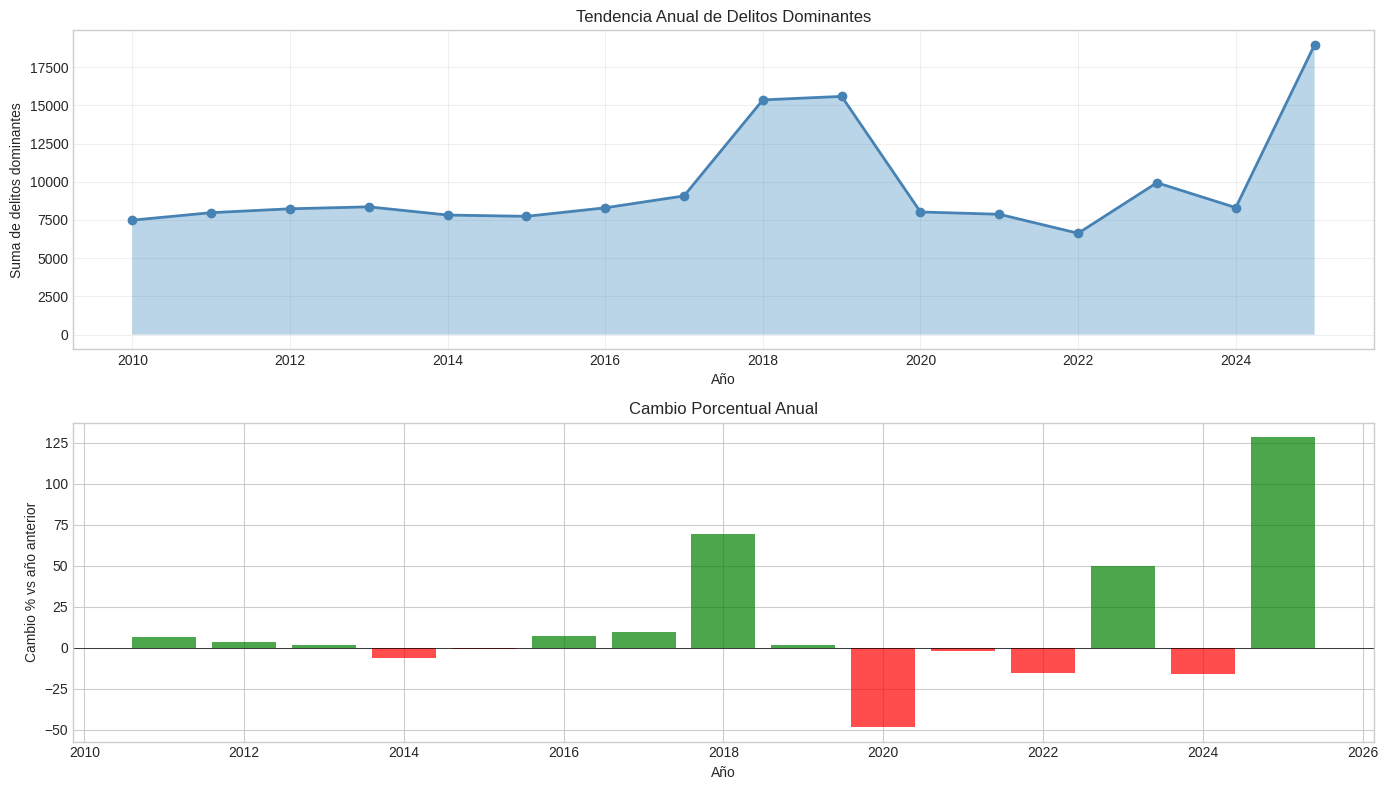

In [6]:
# 2.1 Tendencia anual de delitos
print("=" * 60)
print("TENDENCIAS ANUALES")
print("=" * 60)

# Suma de delitos por año
delitos_por_anio = df.groupby('anio')['count_delito'].sum()
armas_por_anio = df.groupby('anio')['count_arma'].sum()

# Calcular cambio porcentual año a año
cambio_anual = delitos_por_anio.pct_change() * 100

print("\n📊 Suma de delitos dominantes por año:")
for anio, total in delitos_por_anio.items():
    cambio = cambio_anual.get(anio, 0)
    cambio_str = f"({cambio:+.1f}%)" if pd.notna(cambio) and anio != anio_min else ""
    print(f"   {anio}: {total:,} {cambio_str}")

# Visualización
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Gráfico de línea - Tendencia
ax1 = axes[0]
ax1.plot(delitos_por_anio.index, delitos_por_anio.values, marker='o', linewidth=2, color='steelblue')
ax1.fill_between(delitos_por_anio.index, delitos_por_anio.values, alpha=0.3)
ax1.set_xlabel('Año')
ax1.set_ylabel('Suma de delitos dominantes')
ax1.set_title('Tendencia Anual de Delitos Dominantes')
ax1.grid(True, alpha=0.3)

# Gráfico de barras - Cambio porcentual
ax2 = axes[1]
colors = ['green' if x >= 0 else 'red' for x in cambio_anual.dropna().values]
ax2.bar(cambio_anual.dropna().index, cambio_anual.dropna().values, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Año')
ax2.set_ylabel('Cambio % vs año anterior')
ax2.set_title('Cambio Porcentual Anual')

plt.tight_layout()
plt.show()

# Guardar tendencias
tendencias_anuales = {
    'delitos_por_anio': {int(k): int(v) for k, v in delitos_por_anio.items()},
    'cambio_porcentual': {int(k): round(v, 2) for k, v in cambio_anual.dropna().items()},
    'tendencia_general': 'creciente' if delitos_por_anio.iloc[-1] > delitos_por_anio.iloc[0] else 'decreciente'
}


ESTACIONALIDAD MENSUAL

📊 Promedio de delitos dominantes por mes:
   Ene: 9.9 ⬆️
   Feb: 9.2   
   Mar: 9.8   
   Abr: 9.3   
   May: 9.7   
   Jun: 9.1   
   Jul: 9.8   
   Ago: 9.7   
   Sep: 9.8   
   Oct: 9.1   
   Nov: 8.0 ⬇️
   Dic: 8.4   

🔴 Mes más crítico: Ene (promedio: 9.9)
🟢 Mes más tranquilo: Nov (promedio: 8.0)


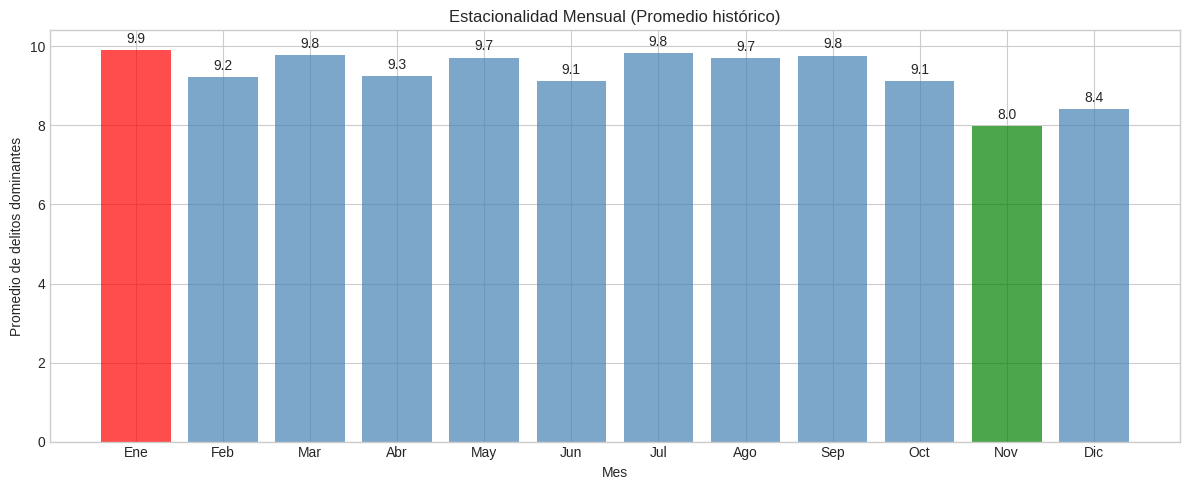

In [7]:
# 2.2 Estacionalidad mensual
print("\n" + "=" * 60)
print("ESTACIONALIDAD MENSUAL")
print("=" * 60)

# Promedio de delitos por mes (a través de todos los años)
delitos_por_mes = df.groupby('mes')['count_delito'].mean()

meses_nombres = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

mes_mas_alto = delitos_por_mes.idxmax()
mes_mas_bajo = delitos_por_mes.idxmin()

print(f"\n📊 Promedio de delitos dominantes por mes:")
for mes, promedio in delitos_por_mes.items():
    indicador = "⬆️" if mes == mes_mas_alto else ("⬇️" if mes == mes_mas_bajo else "  ")
    print(f"   {meses_nombres[mes-1]}: {promedio:.1f} {indicador}")

print(f"\n🔴 Mes más crítico: {meses_nombres[mes_mas_alto-1]} (promedio: {delitos_por_mes[mes_mas_alto]:.1f})")
print(f"🟢 Mes más tranquilo: {meses_nombres[mes_mas_bajo-1]} (promedio: {delitos_por_mes[mes_mas_bajo]:.1f})")

# Visualización
fig, ax = plt.subplots(figsize=(12, 5))
colors = ['red' if m == mes_mas_alto else ('green' if m == mes_mas_bajo else 'steelblue') 
          for m in delitos_por_mes.index]
bars = ax.bar(meses_nombres, delitos_por_mes.values, color=colors, alpha=0.7)
ax.set_xlabel('Mes')
ax.set_ylabel('Promedio de delitos dominantes')
ax.set_title('Estacionalidad Mensual (Promedio histórico)')
ax.bar_label(bars, fmt='%.1f', padding=3)
plt.tight_layout()
plt.show()

# Guardar estacionalidad
tendencias_anuales['estacionalidad_mensual'] = {
    meses_nombres[int(k)-1]: round(v, 2) for k, v in delitos_por_mes.items()
}
tendencias_anuales['mes_mas_critico'] = meses_nombres[mes_mas_alto-1]
tendencias_anuales['mes_mas_tranquilo'] = meses_nombres[mes_mas_bajo-1]


EVOLUCIÓN DEL TIPO DE DELITO DOMINANTE

📊 Delito más frecuente como dominante por año:
   2010: LESIONES
   2011: LESIONES
   2012: LESIONES
   2013: LESIONES
   2014: LESIONES
   2015: LESIONES
   2016: LESIONES
   2017: LESIONES
   2018: LESIONES
   2019: LESIONES
   2020: ABIGEATO
   2021: ABIGEATO
   2022: LESIONES
   2023: LESIONES
   2024: LESIONES
   2025: ABIGEATO


/tmp/ipykernel_29702/1591375448.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delito_anio_pivot = df.groupby(['anio', 'delito_dominante']).size().unstack(fill_value=0)


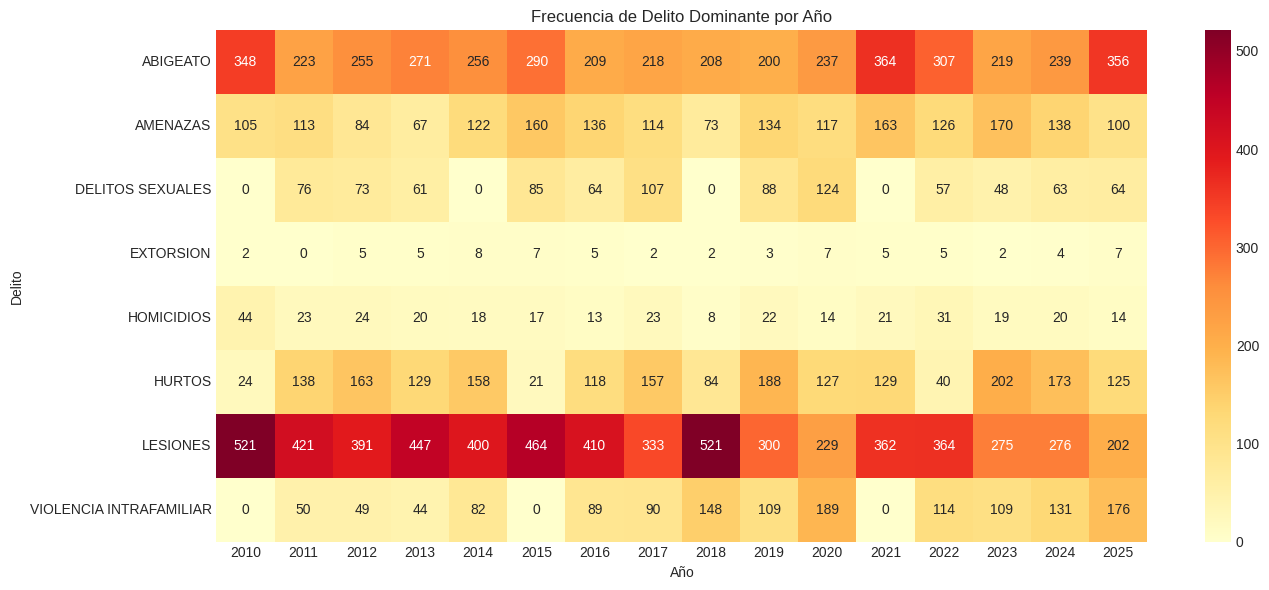

In [8]:
# 2.3 Evolución del delito dominante por año
print("\n" + "=" * 60)
print("EVOLUCIÓN DEL TIPO DE DELITO DOMINANTE")
print("=" * 60)

# Delito más frecuente como dominante por año
delito_dominante_por_anio = df.groupby('anio')['delito_dominante'].agg(
    lambda x: x.value_counts().idxmax()
)

print("\n📊 Delito más frecuente como dominante por año:")
for anio, delito in delito_dominante_por_anio.items():
    print(f"   {anio}: {delito}")

# Heatmap de delitos por año
delito_anio_pivot = df.groupby(['anio', 'delito_dominante']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(delito_anio_pivot.T, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
ax.set_title('Frecuencia de Delito Dominante por Año')
ax.set_xlabel('Año')
ax.set_ylabel('Delito')
plt.tight_layout()
plt.show()

tendencias_anuales['delito_dominante_por_anio'] = {int(k): str(v) for k, v in delito_dominante_por_anio.items()}

---
## 3. Análisis por Municipio (Rankings)

In [9]:
# 3.1 Ranking de municipios por total de delitos
print("=" * 60)
print("RANKING DE MUNICIPIOS")
print("=" * 60)

# Agregar por municipio
municipios_stats = df.groupby('codigo_municipio').agg({
    'count_delito': ['sum', 'mean', 'std'],
    'count_arma': ['sum', 'mean'],
    'delito_dominante': lambda x: x.value_counts().idxmax(),
    'arma_dominante': lambda x: x.value_counts().idxmax(),
    'anio': ['min', 'max']
}).round(2)

municipios_stats.columns = ['total_delitos', 'promedio_mensual', 'desviacion', 
                            'total_armas', 'promedio_armas',
                            'delito_mas_frecuente', 'arma_mas_frecuente',
                            'anio_inicio', 'anio_fin']

municipios_stats = municipios_stats.sort_values('total_delitos', ascending=False)
municipios_stats['ranking'] = range(1, len(municipios_stats) + 1)

print("\n🏆 Top 10 municipios con más delitos dominantes:")
print(municipios_stats[['ranking', 'total_delitos', 'promedio_mensual', 'delito_mas_frecuente']].head(10).to_string())

print("\n🏆 Top 10 municipios con menos delitos dominantes:")
print(municipios_stats[['ranking', 'total_delitos', 'promedio_mensual', 'delito_mas_frecuente']].tail(10).to_string())

RANKING DE MUNICIPIOS

🏆 Top 10 municipios con más delitos dominantes:
                  ranking  total_delitos  promedio_mensual delito_mas_frecuente
codigo_municipio                                                               
68001                   1          49283            256.68             LESIONES
68276                   2          17679             92.08               HURTOS
68081                   3          16945             88.26             LESIONES
68307                   4          12218             63.64             LESIONES
68547                   5          11881             61.88             LESIONES
68679                   6           4533             23.61             LESIONES
68077                   7           3617             18.84             LESIONES
68406                   8           2741             14.28             LESIONES
68655                   9           2654             13.82             LESIONES
68190                  10           2644         

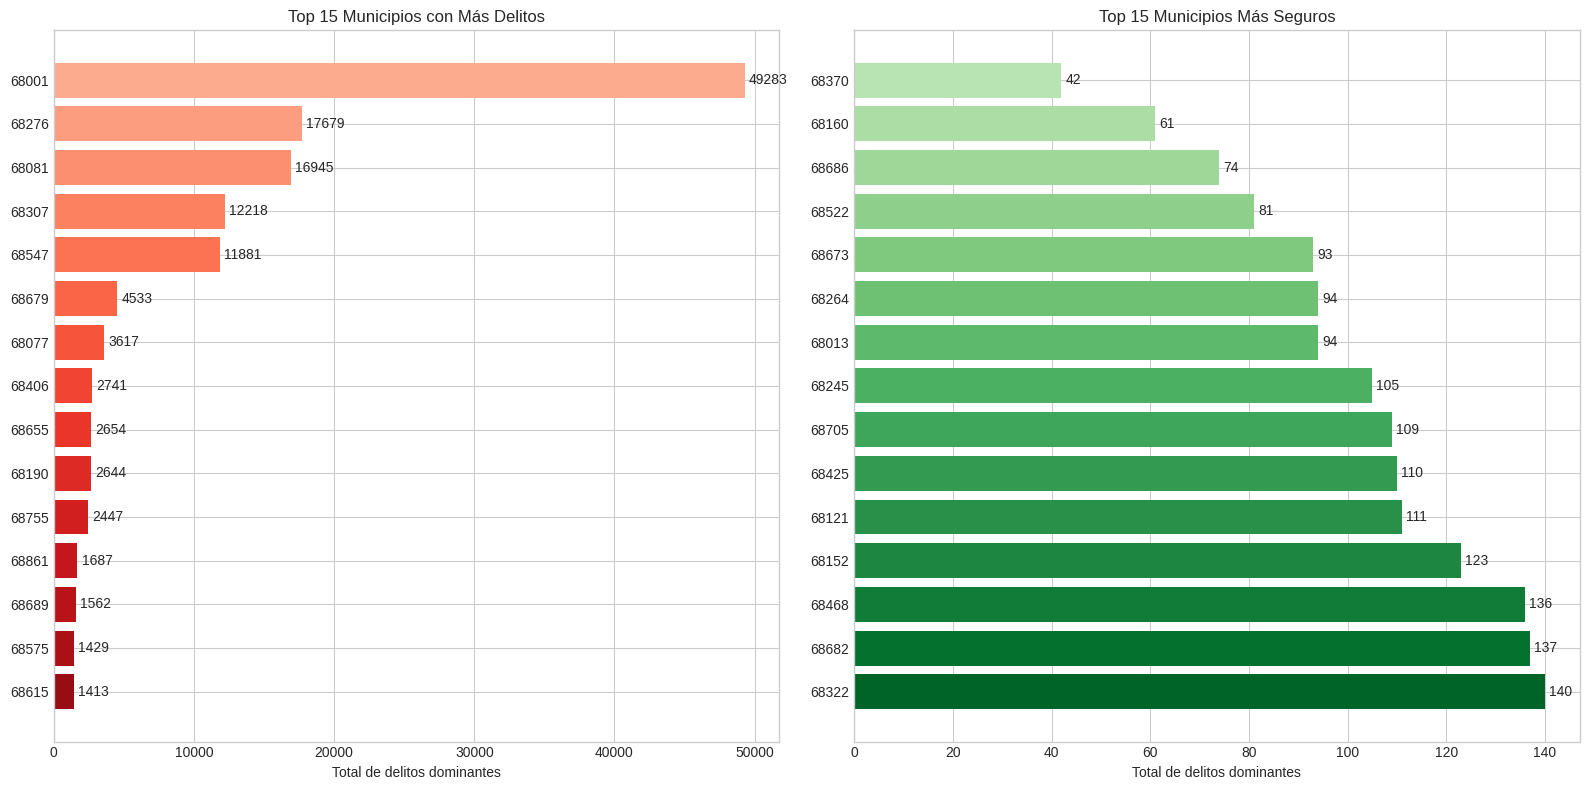

In [10]:
# 3.2 Visualización del ranking
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 municipios
top15 = municipios_stats.head(15)
ax1 = axes[0]
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 15))
bars = ax1.barh(top15.index.astype(str), top15['total_delitos'], color=colors)
ax1.set_xlabel('Total de delitos dominantes')
ax1.set_title('Top 15 Municipios con Más Delitos')
ax1.bar_label(bars, fmt='%d', padding=3)
ax1.invert_yaxis()

# Bottom 15 municipios (más seguros)
bottom15 = municipios_stats.tail(15).iloc[::-1]
ax2 = axes[1]
colors = plt.cm.Greens(np.linspace(0.3, 0.9, 15))
bars = ax2.barh(bottom15.index.astype(str), bottom15['total_delitos'], color=colors)
ax2.set_xlabel('Total de delitos dominantes')
ax2.set_title('Top 15 Municipios Más Seguros')
ax2.bar_label(bars, fmt='%d', padding=3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


CLASIFICACIÓN DE RIESGO POR MUNICIPIO

📊 Distribución de municipios por categoría de riesgo:
   Medio-Bajo: 23 municipios
   Alto: 22 municipios
   Bajo: 22 municipios
   Medio-Alto: 20 municipios

📊 Umbrales de clasificación:
   Bajo: promedio ≤ 0.89
   Medio-Bajo: 0.89 < promedio ≤ 1.57
   Medio-Alto: 1.57 < promedio ≤ 3.33
   Alto: promedio > 3.33


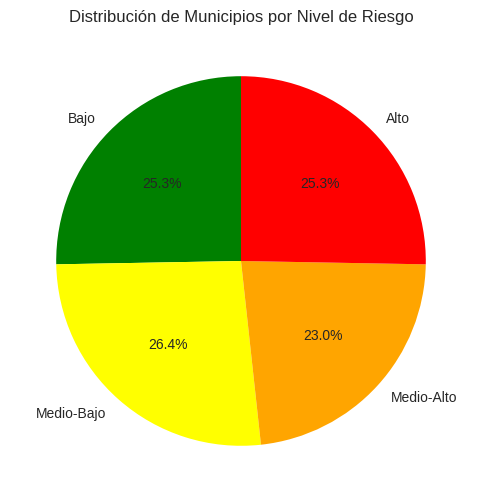

In [11]:
# 3.3 Clasificación de riesgo por municipio
print("\n" + "=" * 60)
print("CLASIFICACIÓN DE RIESGO POR MUNICIPIO")
print("=" * 60)

# Calcular percentiles para clasificar
p25 = municipios_stats['promedio_mensual'].quantile(0.25)
p50 = municipios_stats['promedio_mensual'].quantile(0.50)
p75 = municipios_stats['promedio_mensual'].quantile(0.75)

def clasificar_riesgo(promedio):
    if promedio <= p25:
        return 'Bajo'
    elif promedio <= p50:
        return 'Medio-Bajo'
    elif promedio <= p75:
        return 'Medio-Alto'
    else:
        return 'Alto'

municipios_stats['categoria_riesgo'] = municipios_stats['promedio_mensual'].apply(clasificar_riesgo)

# Contar por categoría
riesgo_counts = municipios_stats['categoria_riesgo'].value_counts()

print(f"\n📊 Distribución de municipios por categoría de riesgo:")
for cat, count in riesgo_counts.items():
    print(f"   {cat}: {count} municipios")

print(f"\n📊 Umbrales de clasificación:")
print(f"   Bajo: promedio ≤ {p25:.2f}")
print(f"   Medio-Bajo: {p25:.2f} < promedio ≤ {p50:.2f}")
print(f"   Medio-Alto: {p50:.2f} < promedio ≤ {p75:.2f}")
print(f"   Alto: promedio > {p75:.2f}")

# Visualización
fig, ax = plt.subplots(figsize=(8, 6))
colors_riesgo = {'Bajo': 'green', 'Medio-Bajo': 'yellow', 'Medio-Alto': 'orange', 'Alto': 'red'}
riesgo_order = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
riesgo_counts_ordered = riesgo_counts.reindex(riesgo_order)
colors = [colors_riesgo[r] for r in riesgo_counts_ordered.index]
ax.pie(riesgo_counts_ordered.values, labels=riesgo_counts_ordered.index, 
       autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Distribución de Municipios por Nivel de Riesgo')
plt.show()

---
## 4. Resumen por Municipio (Para Chatbot)

In [12]:
# 4.1 Generar resumen detallado por municipio
print("=" * 60)
print("GENERANDO RESÚMENES POR MUNICIPIO")
print("=" * 60)

# Calcular métricas adicionales por municipio
municipios_resumen = {}

# Promedio departamental para comparación
promedio_depto = municipios_stats['promedio_mensual'].mean()

for codigo in df['codigo_municipio'].unique():
    df_mun = df[df['codigo_municipio'] == codigo]
    stats = municipios_stats.loc[codigo]
    
    # Tendencia del último año disponible
    ultimo_anio = df_mun['anio'].max()
    penultimo_anio = ultimo_anio - 1
    
    delitos_ultimo = df_mun[df_mun['anio'] == ultimo_anio]['count_delito'].sum()
    delitos_penultimo = df_mun[df_mun['anio'] == penultimo_anio]['count_delito'].sum()
    
    if delitos_penultimo > 0:
        cambio_anual = ((delitos_ultimo - delitos_penultimo) / delitos_penultimo) * 100
    else:
        cambio_anual = 0
    
    # Mes más crítico para este municipio
    mes_critico = df_mun.groupby('mes')['count_delito'].mean().idxmax()
    
    # Variabilidad del delito dominante
    delitos_unicos = df_mun['delito_dominante'].nunique()
    
    # Comparación con promedio departamental
    vs_promedio = ((stats['promedio_mensual'] - promedio_depto) / promedio_depto) * 100
    
    municipios_resumen[int(codigo)] = {
        'codigo_municipio': int(codigo),
        'ranking_departamental': int(stats['ranking']),
        'categoria_riesgo': str(stats['categoria_riesgo']),
        'total_delitos': int(stats['total_delitos']),
        'promedio_mensual': round(float(stats['promedio_mensual']), 2),
        'delito_mas_frecuente': str(stats['delito_mas_frecuente']),
        'arma_mas_frecuente': str(stats['arma_mas_frecuente']),
        'mes_mas_critico': meses_nombres[int(mes_critico)-1],
        'tendencia': {
            'cambio_vs_anio_anterior': round(cambio_anual, 2),
            'direccion': 'aumentando' if cambio_anual > 5 else ('disminuyendo' if cambio_anual < -5 else 'estable')
        },
        'comparativa': {
            'vs_promedio_depto': round(vs_promedio, 2),
            'descripcion': 'por encima' if vs_promedio > 0 else 'por debajo'
        },
        'variabilidad_delitos': int(delitos_unicos)
    }

print(f"\n✅ Resúmenes generados para {len(municipios_resumen)} municipios")

# Mostrar ejemplo
ejemplo_codigo = list(municipios_resumen.keys())[0]
print(f"\n📋 Ejemplo de resumen (municipio {ejemplo_codigo}):")
print(json.dumps(municipios_resumen[ejemplo_codigo], indent=2, ensure_ascii=False))

GENERANDO RESÚMENES POR MUNICIPIO

✅ Resúmenes generados para 87 municipios

📋 Ejemplo de resumen (municipio 68001):
{
  "codigo_municipio": 68001,
  "ranking_departamental": 1,
  "categoria_riesgo": "Alto",
  "total_delitos": 49283,
  "promedio_mensual": 256.68,
  "delito_mas_frecuente": "LESIONES",
  "arma_mas_frecuente": "SIN EMPLEO DE ARMAS",
  "mes_mas_critico": "Sep",
  "tendencia": {
    "cambio_vs_anio_anterior": 298.91,
    "direccion": "aumentando"
  },
  "comparativa": {
    "vs_promedio_depto": 2653.87,
    "descripcion": "por encima"
  },
  "variabilidad_delitos": 3
}


In [13]:
# 4.2 Generar texto descriptivo para chatbot
print("\n" + "=" * 60)
print("TEXTOS PARA CHATBOT")
print("=" * 60)

def generar_descripcion(resumen):
    """Genera una descripción en lenguaje natural para el chatbot"""
    codigo = resumen['codigo_municipio']
    
    descripcion = f"""El municipio con código {codigo} ocupa el puesto #{resumen['ranking_departamental']} 
en el departamento y tiene un nivel de riesgo {resumen['categoria_riesgo']}. 

El delito más frecuente es {resumen['delito_mas_frecuente']}, generalmente cometido con 
{resumen['arma_mas_frecuente']}. El mes más crítico históricamente es {resumen['mes_mas_critico']}.

Respecto al año anterior, la criminalidad está {resumen['tendencia']['direccion']} 
({resumen['tendencia']['cambio_vs_anio_anterior']:+.1f}%). 

Comparado con el promedio departamental, este municipio está {resumen['comparativa']['descripcion']} 
del promedio ({resumen['comparativa']['vs_promedio_depto']:+.1f}%)."""
    
    return descripcion.replace('\n', ' ').replace('  ', ' ')

# Agregar descripciones a los resúmenes
for codigo, resumen in municipios_resumen.items():
    resumen['descripcion_chatbot'] = generar_descripcion(resumen)

# Mostrar ejemplo
print(f"\n📝 Ejemplo de descripción para chatbot:")
print(f"\n{municipios_resumen[ejemplo_codigo]['descripcion_chatbot']}")


TEXTOS PARA CHATBOT

📝 Ejemplo de descripción para chatbot:

El municipio con código 68001 ocupa el puesto #1 en el departamento y tiene un nivel de riesgo Alto.  El delito más frecuente es LESIONES, generalmente cometido con SIN EMPLEO DE ARMAS. El mes más crítico históricamente es Sep. Respecto al año anterior, la criminalidad está aumentando (+298.9%).  Comparado con el promedio departamental, este municipio está por encima del promedio (+2653.9%).


---
## 5. Guardar Resultados

In [14]:
# 5.1 Guardar todos los archivos JSON
print("=" * 60)
print("GUARDANDO RESULTADOS")
print("=" * 60)

# 1. Estadísticas generales
with open(OUTPUT_DIR / 'estadisticas_generales.json', 'w', encoding='utf-8') as f:
    json.dump(stats_generales, f, indent=2, ensure_ascii=False)
print(f"✅ Guardado: estadisticas_generales.json")

# 2. Tendencias anuales
with open(OUTPUT_DIR / 'tendencias_anuales.json', 'w', encoding='utf-8') as f:
    json.dump(tendencias_anuales, f, indent=2, ensure_ascii=False)
print(f"✅ Guardado: tendencias_anuales.json")

# 3. Resúmenes por municipio
with open(OUTPUT_DIR / 'municipios_resumen.json', 'w', encoding='utf-8') as f:
    json.dump(municipios_resumen, f, indent=2, ensure_ascii=False)
print(f"✅ Guardado: municipios_resumen.json")

# 4. Metadata
metadata = {
    'modelo': 'descriptivo',
    'nombre': 'classification_dominant',
    'descripcion': 'Análisis descriptivo de delitos y armas dominantes por municipio',
    'creado': pd.Timestamp.now().isoformat(),
    'fuente_datos': str(DATA_PATH),
    'archivos_generados': [
        'estadisticas_generales.json',
        'tendencias_anuales.json',
        'municipios_resumen.json'
    ],
    'uso': {
        'tablero': 'Visualizaciones y métricas agregadas',
        'chatbot': 'Respuestas contextualizadas usando campo descripcion_chatbot'
    }
}

with open(OUTPUT_DIR / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f"✅ Guardado: metadata.json")

print(f"\n📁 Todos los archivos guardados en: {OUTPUT_DIR}")
print(f"\n📋 Archivos generados:")
for file in sorted(OUTPUT_DIR.iterdir()):
    size = file.stat().st_size / 1024
    print(f"   - {file.name} ({size:.1f} KB)")

GUARDANDO RESULTADOS
✅ Guardado: estadisticas_generales.json
✅ Guardado: tendencias_anuales.json
✅ Guardado: municipios_resumen.json
✅ Guardado: metadata.json

📁 Todos los archivos guardados en: /home/byverbel/challenges/Datos-al-Ecosistema/models/descriptivo/classification_dominant

📋 Archivos generados:
   - estadisticas_generales.json (4.6 KB)
   - metadata.json (0.6 KB)
   - municipios_resumen.json (79.3 KB)
   - tendencias_anuales.json (1.4 KB)
✅ Guardado: municipios_resumen.json
✅ Guardado: metadata.json

📁 Todos los archivos guardados en: /home/byverbel/challenges/Datos-al-Ecosistema/models/descriptivo/classification_dominant

📋 Archivos generados:
   - estadisticas_generales.json (4.6 KB)
   - metadata.json (0.6 KB)
   - municipios_resumen.json (79.3 KB)
   - tendencias_anuales.json (1.4 KB)


---
## 6. Ejemplo de Uso para el Chatbot

In [15]:
# 6.1 Simulación de consultas al chatbot
print("=" * 60)
print("SIMULACIÓN DE CONSULTAS AL CHATBOT")
print("=" * 60)

def responder_consulta(pregunta, codigo_municipio=None):
    """Simula respuestas del chatbot usando los datos descriptivos"""
    
    pregunta_lower = pregunta.lower()
    
    # Pregunta sobre municipio específico
    if codigo_municipio and codigo_municipio in municipios_resumen:
        mun = municipios_resumen[codigo_municipio]
        
        if 'delito' in pregunta_lower and 'común' in pregunta_lower:
            return f"En el municipio {codigo_municipio}, el delito más común es {mun['delito_mas_frecuente']}."
        
        elif 'seguro' in pregunta_lower or 'riesgo' in pregunta_lower:
            return f"El municipio {codigo_municipio} tiene un nivel de riesgo {mun['categoria_riesgo']} y ocupa el puesto #{mun['ranking_departamental']} en el departamento."
        
        elif 'tendencia' in pregunta_lower or 'aumentado' in pregunta_lower:
            return f"La criminalidad en el municipio {codigo_municipio} está {mun['tendencia']['direccion']} ({mun['tendencia']['cambio_vs_anio_anterior']:+.1f}% vs año anterior)."
        
        elif 'mes' in pregunta_lower and 'peligroso' in pregunta_lower:
            return f"En el municipio {codigo_municipio}, el mes más crítico históricamente es {mun['mes_mas_critico']}."
        
        else:
            return mun['descripcion_chatbot']
    
    # Preguntas generales
    elif 'más peligroso' in pregunta_lower or 'más delitos' in pregunta_lower:
        top3 = [m for m in municipios_resumen.values() if m['ranking_departamental'] <= 3]
        return f"Los municipios con más delitos son: {', '.join([str(m['codigo_municipio']) for m in top3])}."
    
    elif 'más seguro' in pregunta_lower:
        seguros = [m for m in municipios_resumen.values() if m['categoria_riesgo'] == 'Bajo'][:3]
        return f"Algunos de los municipios más seguros son: {', '.join([str(m['codigo_municipio']) for m in seguros])}."
    
    elif 'delito' in pregunta_lower and 'común' in pregunta_lower and 'santander' in pregunta_lower:
        return f"En Santander, el delito más frecuente como dominante es {stats_generales['delito_mas_frecuente']['nombre']} ({stats_generales['delito_mas_frecuente']['porcentaje']}%)."
    
    else:
        return "No tengo información suficiente para responder esa pregunta."

# Ejemplos de consultas
consultas = [
    ("¿Cuál es el delito más común en Santander?", None),
    ("¿Cuál es el delito más común?", 68001),
    ("¿Qué tan seguro es este municipio?", 68001),
    ("¿Ha aumentado la criminalidad?", 68001),
    ("¿Cuál es el mes más peligroso?", 68001),
    ("¿Cuáles son los municipios más peligrosos?", None),
    ("Dame información general", 68001),
]

for pregunta, codigo in consultas:
    print(f"\n👤 Usuario: {pregunta}" + (f" (municipio {codigo})" if codigo else ""))
    respuesta = responder_consulta(pregunta, codigo)
    print(f"🤖 Chatbot: {respuesta}")

SIMULACIÓN DE CONSULTAS AL CHATBOT

👤 Usuario: ¿Cuál es el delito más común en Santander?
🤖 Chatbot: En Santander, el delito más frecuente como dominante es LESIONES (35.42%).

👤 Usuario: ¿Cuál es el delito más común? (municipio 68001)
🤖 Chatbot: En el municipio 68001, el delito más común es LESIONES.

👤 Usuario: ¿Qué tan seguro es este municipio? (municipio 68001)
🤖 Chatbot: El municipio 68001 tiene un nivel de riesgo Alto y ocupa el puesto #1 en el departamento.

👤 Usuario: ¿Ha aumentado la criminalidad? (municipio 68001)
🤖 Chatbot: La criminalidad en el municipio 68001 está aumentando (+298.9% vs año anterior).

👤 Usuario: ¿Cuál es el mes más peligroso? (municipio 68001)
🤖 Chatbot: En el municipio 68001, el mes más crítico históricamente es Sep.

👤 Usuario: ¿Cuáles son los municipios más peligrosos?
🤖 Chatbot: Los municipios con más delitos son: 68001, 68081, 68276.

👤 Usuario: Dame información general (municipio 68001)
🤖 Chatbot: El municipio con código 68001 ocupa el puesto #1 en 

---
## 7. Conclusiones

### Archivos Generados

| Archivo | Descripción | Uso Principal |
|---------|-------------|---------------|
| `estadisticas_generales.json` | Métricas globales de Santander | Tablero - Vista general |
| `tendencias_anuales.json` | Evolución temporal y estacionalidad | Tablero - Gráficos de tendencia |
| `municipios_resumen.json` | Resumen detallado por municipio | Chatbot - Respuestas contextualizadas |
| `metadata.json` | Información del análisis | Documentación |

### Uso en el Tablero Web

- Visualizar ranking de municipios
- Mostrar tendencias temporales
- Colorear mapa por categoría de riesgo
- Filtrar por tipo de delito/arma

### Uso en el Chatbot

- Campo `descripcion_chatbot` listo para respuestas
- Datos estructurados para consultas específicas
- Comparativas con promedio departamental